# Size Structure distribution

This notebook explores the possibility of parameterizing the size distribution of plankton by the number of plankton in a specific mass range and the total biomass. To do so, we need to import several python libraries.

In [1]:
#import math
#import matplotlib
import numpy as np
from scipy import optimize
#from scipy import stats
#from scipy.stats import lognorm
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # Large figures

## Starting Point

A common assumption to make is that the relationship between the size of plankton and its abundance is log-linear. We state that explicitly by defining *s* to be the equivalent spherical diameter (ESD) and *n(s)* to be abundance:

*n(s) = n<sub>0</sub>(s/s<sub>0</sub>)<sup>-x</sup>*

Where *n<sub>0</sub>* is the abundance at a given size *s<sub>0</sub>* and *-x* defines the slope in the log-linear relationship (the *-* is included because larger plankton are less abundant and it is useful for *x>0*).

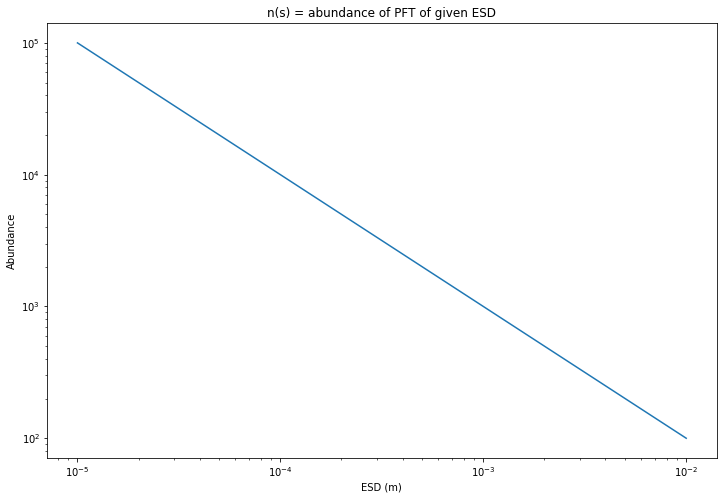

In [2]:
# s is Plankton ESD (in meters); 10 um -> 1 cm seems like a reasonable range
s = 10**(np.linspace(-5, -2, num=100))

def n(s):
    s0 = 1
    n0 = 1
    x = 1
    return n0 * (s/s0)**-x

plt.loglog(s, n(s));
plt.title('n(s) = abundance of PFT of given ESD'); plt.xlabel('ESD (m)'); plt.ylabel('Abundance');

# We will redefine n [permanently] later in the notebook
del n

We also know that there is a power law relating plankton ESD and plankton mass. Defining the mass to be *m*, we state that relationship as

*m(s) = C<sub>1</sub>(s/s<sub>0</sub>)<sup>C<sub>2</sub></sup>*

Where *C<sub>1</sub>* and *C<sub>2</sub>* are parameters we need to get from the literature.

It should also be pointed out that, for a size range *[s<sub>1</sub>,s<sub>2</sub>]* the total plankton count is

N = I*<sub>s<sub>1</sub></sub><sup>s<sub>2</sub></sup> n(s)m'(s)ds*

and the total plankton mass is

M(s) = I*<sub>s<sub>1</sub></sub><sup>s<sub>2</sub></sup> n(s)m(s)m'(s)ds*

where I is the integral operator. So if we know *C<sub>1</sub>*, *C<sub>2</sub>*, and *s<sub>0</sub>* then we can define plankton count and mass for a size range *[s<sub>1</sub>,s<sub>2</sub>]* as a function of *n<sub>0</sub>* and *x*:

In [3]:
# Definite integral of f(t) = t^y (assume y is an array, t1 & t2 are scalar)
def power_int(y, t1, t2):
    return np.where(y == -1, np.log(t2) - np.log(t1), (t2**(y+1.) - t1**(y+1.))/(y+1.))

def N(n0,x):
    return n0*c1*c2*(s0**(x-c2))*power_int(c2-1-x,s1,s2)

def M(n0,x):
    return n0*c1*(s0**(x-2*c2))*power_int(2*c2-1-x,s1,s2)

To see if this function is invertible, we look at contours of *N* and *M* for some realistic choices of the parameters *C<sub>1</sub>*, *C<sub>2</sub>*, *s<sub>1</sub>*, *s<sub>2</sub>*, and *s<sub>0</sub>* and over reasonable ranges of *(n<sub>0</sub>, x)*-space

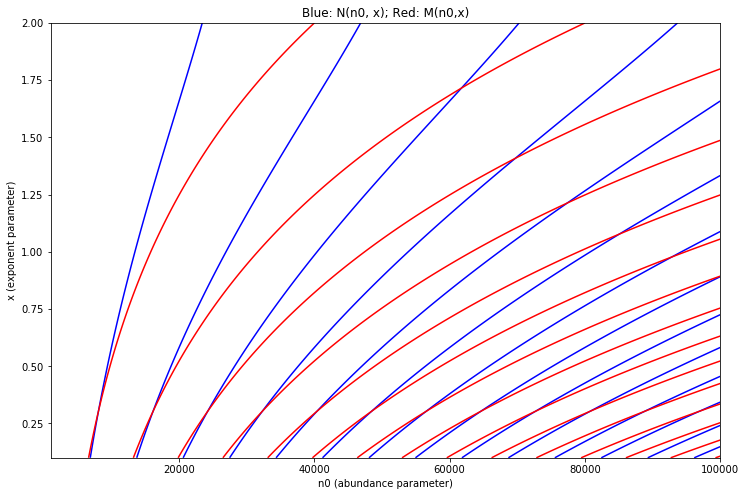

In [4]:
c1 = 1
c2 = 3
s1 = 10**-4
s2 = 10**-3
# For now we take s0 to be geometric mean of s1 and s2
s0 = np.sqrt(s1*s2)

# x between 0.1 and 2
x = np.linspace(0.1, 2, num=191)

# n0 between 1000 and 100000
n0 = 10**(np.linspace(3,5,num=201))

# grid for contours
X, Y = np.meshgrid(n0, x)
plt.rcParams['contour.negative_linestyle'] = 'solid';
plt.contour(X, Y, N(X,Y), 16, colors='b');
plt.contour(X, Y, M(X,Y), 16, colors='r');
plt.title("Blue: N(n0, x); Red: M(n0,x)")
plt.xlabel("n0 (abundance parameter)"); plt.ylabel("x (exponent parameter)");


It does appear as though the mapping from *(n<sub>0</sub>, x)* to *(N, M)* is one to one... so the next step is to determine *n<sub>0</sub>(N,M)* and *x(N,M)*. A good place to start is by noting that

*N(n<sub>0</sub>,x) = n<sub>0</sub>F(x)*
*M(n<sub>0</sub>,x) = n<sub>0</sub>G(x)*

So given *N(n<sub>0</sub>,x) = N<sub>1</sub>* and *M(n<sub>0</sub>,x) = M<sub>1</sub>* it follows that

*M<sub>1</sub> / N<sub>1</sub> = G(x)/F(x)* is a function purely of *x*; if *G(x)/F(x)* is invertible that yields *x(N,M)*

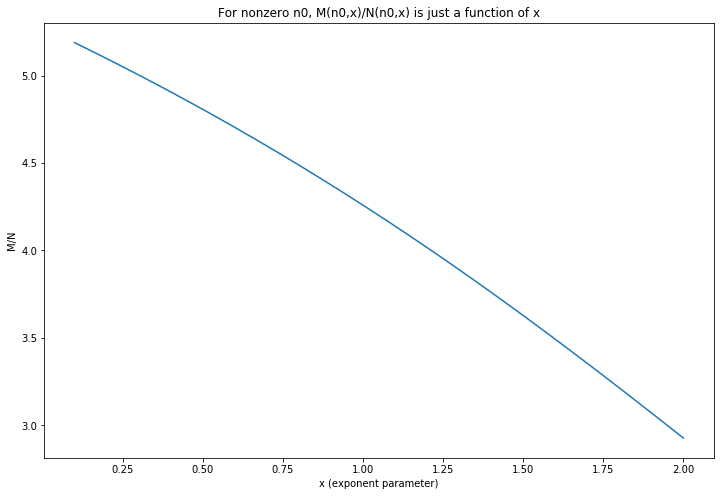

In [5]:
def F(x):
    return N(1,x)

def G(x):
    return M(1,x)

plt.plot(x,G(x)/F(x));
plt.title("For nonzero n0, M(n0,x)/N(n0,x) is just a function of x");
plt.xlabel("x (exponent parameter)"); plt.ylabel("M/N");


In fact, *G(x)/F(x)* appears nearly linear, so an iterative solver should make quick work of finding *x*.

Once we know *x* then *n<sub>0</sub>* falls out from either

*N(n<sub>0</sub>,x)=n<sub>0</sub>F(x)* => *n<sub>0</sub>=N<sub>1</sub>/F(x)*

or

*M(n<sub>0</sub>,x)=n<sub>0</sub>G(x)* => *n<sub>0</sub>=M<sub>1</sub>/G(x)*

To test this out with concrete numbers, let's take *n<sub>0</sub>=10<sup>4</sup>* and *x=-1.05*

In [6]:
x = -1.05
n0 = 10**4
N1 = N(n0,x)
M1 = M(n0,x)
del x, n0

print N1,M1

784562.458585 4751282.40148


Given *N<sub>1</sub>* and *M<sub>1</sub>* above, can we find *x* and *n<sub>0</sub>*?

In [7]:
def find_x(x):
    return G(x)/F(x) - M1/N1

def find_n0(n0):
    return 

x = optimize.fsolve(find_x,-1)
n0 = N1/F(x)
print x, n0

[-1.05] [ 10000.]


The above shows we can, the next step (I think) is to write a python script that does the root-finding instead of relying on optimize.fsolve (that is what we will need to translate to Fortran for MARBL); I think that will require defining *F(x)*, *F'(x)*, *G(x)*, and *G'(x)* explicitly; from the plot above, Newton's method seems like a reasonable way to solve for *x*